## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# # load the data if you need to; if you have already loaded the data, you may comment this cell out
# # -- DO NOT CHANGE THIS CELL -- #
# !mkdir /data
# !wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n /data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (drop_layer): Dropout(p=0.2)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=136, bias=True)
)


/home/thojo/work/ud/vision/facial_keypoint_detection/models.py:25: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  I.kaiming_normal(self.conv1.weight)
/home/thojo/work/ud/vision/facial_keypoint_detection/models.py:34: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  I.kaiming_normal(self.conv2.weight)
/home/thojo/work/ud/vision/facial_keypoint_detection/models.py:38: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  I.kaiming_normal(self.conv3.weight)
/home/thojo/work/ud/vision/facial_keypoint_detection/models.py:41: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  I.kaiming_normal(self.conv4.weight)
/home/thojo/work/ud/vision/facial_keypoint_detection/models.py:44: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  I.kaiming_normal(self.fc1.weight)
/home/thojo/work/ud/vi

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/thojo/work/ud/vision/facial_keypoint_detection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/thojo/work/ud/vision/facial_keypoint_detection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [11]:
test_outputs.size()

torch.Size([10, 68, 2])

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

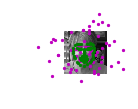

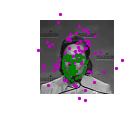

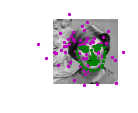

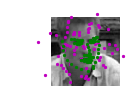

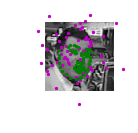

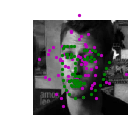

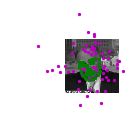

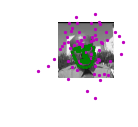

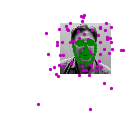

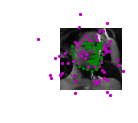

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [16]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

/home/thojo/work/ud/vision/facial_keypoint_detection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.9304021507501602
Epoch: 1, Batch: 20, Avg. Loss: 0.44653855860233305
Epoch: 1, Batch: 30, Avg. Loss: 0.297223787009716
Epoch: 1, Batch: 40, Avg. Loss: 0.4641831234097481
Epoch: 1, Batch: 50, Avg. Loss: 0.27856168895959854
Epoch: 1, Batch: 60, Avg. Loss: 0.27941499203443526
Epoch: 1, Batch: 70, Avg. Loss: 0.21203953474760057
Epoch: 1, Batch: 80, Avg. Loss: 0.255698099732399
Epoch: 1, Batch: 90, Avg. Loss: 0.2377152994275093
Epoch: 1, Batch: 100, Avg. Loss: 0.23625833094120025
Epoch: 1, Batch: 110, Avg. Loss: 0.24573950171470643
Epoch: 1, Batch: 120, Avg. Loss: 0.2072665810585022
Epoch: 1, Batch: 130, Avg. Loss: 0.21578358709812165
Epoch: 1, Batch: 140, Avg. Loss: 0.2370574340224266
Epoch: 1, Batch: 150, Avg. Loss: 0.2819849833846092
Epoch: 1, Batch: 160, Avg. Loss: 0.2491889014840126
Epoch: 1, Batch: 170, Avg. Loss: 0.23136384785175323
Epoch: 1, Batch: 180, Avg. Loss: 0.2026732310652733
Epoch: 1, Batch: 190, Avg. Loss: 0.16814492717385293
Epoch: 1, Batc

Epoch: 4, Batch: 280, Avg. Loss: 0.07429677098989487
Epoch: 4, Batch: 290, Avg. Loss: 0.06733785830438137
Epoch: 4, Batch: 300, Avg. Loss: 0.07211911622434855
Epoch: 4, Batch: 310, Avg. Loss: 0.08604436814785003
Epoch: 4, Batch: 320, Avg. Loss: 0.0803734552115202
Epoch: 4, Batch: 330, Avg. Loss: 0.09474700707942248
Epoch: 4, Batch: 340, Avg. Loss: 0.10631213150918484
Epoch: 4, Batch: 350, Avg. Loss: 0.1094683587551117
Epoch: 4, Batch: 360, Avg. Loss: 0.07126886025071144
Epoch: 4, Batch: 370, Avg. Loss: 0.0791294265538454
Epoch: 4, Batch: 380, Avg. Loss: 0.060937033593654634
Epoch: 4, Batch: 390, Avg. Loss: 0.05716508664190769
Epoch: 4, Batch: 400, Avg. Loss: 0.056372273899614814
Epoch: 4, Batch: 410, Avg. Loss: 0.062209992110729216
Epoch: 4, Batch: 420, Avg. Loss: 0.058430390432477
Epoch: 4, Batch: 430, Avg. Loss: 0.06479942463338376
Epoch: 5, Batch: 10, Avg. Loss: 0.058714963123202325
Epoch: 5, Batch: 20, Avg. Loss: 0.05211032573133707
Epoch: 5, Batch: 30, Avg. Loss: 0.192422404512763

Epoch: 8, Batch: 120, Avg. Loss: 0.058416926115751264
Epoch: 8, Batch: 130, Avg. Loss: 0.07060604803264141
Epoch: 8, Batch: 140, Avg. Loss: 0.06019981931895017
Epoch: 8, Batch: 150, Avg. Loss: 0.046921387687325476
Epoch: 8, Batch: 160, Avg. Loss: 0.05424821339547634
Epoch: 8, Batch: 170, Avg. Loss: 0.07334801331162452
Epoch: 8, Batch: 180, Avg. Loss: 0.04538552351295948
Epoch: 8, Batch: 190, Avg. Loss: 0.07854183465242386
Epoch: 8, Batch: 200, Avg. Loss: 0.07536639012396336
Epoch: 8, Batch: 210, Avg. Loss: 0.06099478639662266
Epoch: 8, Batch: 220, Avg. Loss: 0.048089998215436934
Epoch: 8, Batch: 230, Avg. Loss: 0.045029233954846856
Epoch: 8, Batch: 240, Avg. Loss: 0.06172793451696634
Epoch: 8, Batch: 250, Avg. Loss: 0.06759528163820505
Epoch: 8, Batch: 260, Avg. Loss: 0.05205352902412415
Epoch: 8, Batch: 270, Avg. Loss: 0.05202344786375761
Epoch: 8, Batch: 280, Avg. Loss: 0.04929262511432171
Epoch: 8, Batch: 290, Avg. Loss: 0.0405092628672719
Epoch: 8, Batch: 300, Avg. Loss: 0.05096834

Epoch: 11, Batch: 370, Avg. Loss: 0.08221884481608868
Epoch: 11, Batch: 380, Avg. Loss: 0.04724817425012588
Epoch: 11, Batch: 390, Avg. Loss: 0.12348588481545449
Epoch: 11, Batch: 400, Avg. Loss: 0.0788662813603878
Epoch: 11, Batch: 410, Avg. Loss: 0.12480532936751842
Epoch: 11, Batch: 420, Avg. Loss: 0.07221618331968785
Epoch: 11, Batch: 430, Avg. Loss: 0.07587128486484289
Epoch: 12, Batch: 10, Avg. Loss: 0.06177159305661917
Epoch: 12, Batch: 20, Avg. Loss: 0.04648204278200865
Epoch: 12, Batch: 30, Avg. Loss: 0.05131481308490038
Epoch: 12, Batch: 40, Avg. Loss: 0.05444827787578106
Epoch: 12, Batch: 50, Avg. Loss: 0.05148187093436718
Epoch: 12, Batch: 60, Avg. Loss: 0.03971663862466812
Epoch: 12, Batch: 70, Avg. Loss: 0.05439319647848606
Epoch: 12, Batch: 80, Avg. Loss: 0.04445339273661375
Epoch: 12, Batch: 90, Avg. Loss: 0.05249224454164505
Epoch: 12, Batch: 100, Avg. Loss: 0.05154125653207302
Epoch: 12, Batch: 110, Avg. Loss: 0.31816852167248727
Epoch: 12, Batch: 120, Avg. Loss: 0.04

Epoch: 15, Batch: 180, Avg. Loss: 0.0484223298728466
Epoch: 15, Batch: 190, Avg. Loss: 0.045068641379475596
Epoch: 15, Batch: 200, Avg. Loss: 0.05285500790923834
Epoch: 15, Batch: 210, Avg. Loss: 0.04968692902475595
Epoch: 15, Batch: 220, Avg. Loss: 0.131611355766654
Epoch: 15, Batch: 230, Avg. Loss: 0.035542548447847364
Epoch: 15, Batch: 240, Avg. Loss: 0.11851213499903679
Epoch: 15, Batch: 250, Avg. Loss: 0.042734482884407045
Epoch: 15, Batch: 260, Avg. Loss: 0.03678410947322845
Epoch: 15, Batch: 270, Avg. Loss: 0.05803402364253998
Epoch: 15, Batch: 280, Avg. Loss: 0.07935100812464953
Epoch: 15, Batch: 290, Avg. Loss: 0.09059070460498334
Epoch: 15, Batch: 300, Avg. Loss: 0.05078381355851889
Epoch: 15, Batch: 310, Avg. Loss: 0.054633573070168494
Epoch: 15, Batch: 320, Avg. Loss: 0.06805800348520279
Epoch: 15, Batch: 330, Avg. Loss: 0.06436204724013805
Epoch: 15, Batch: 340, Avg. Loss: 0.0530817911028862
Epoch: 15, Batch: 350, Avg. Loss: 0.04807691033929586
Epoch: 15, Batch: 360, Avg. 

Epoch: 18, Batch: 410, Avg. Loss: 0.06584120132029056
Epoch: 18, Batch: 420, Avg. Loss: 0.04209065902978182
Epoch: 18, Batch: 430, Avg. Loss: 0.037714785523712636
Epoch: 19, Batch: 10, Avg. Loss: 0.17279475908726455
Epoch: 19, Batch: 20, Avg. Loss: 0.03947846163064241
Epoch: 19, Batch: 30, Avg. Loss: 0.03885667901486158
Epoch: 19, Batch: 40, Avg. Loss: 0.09897615946829319
Epoch: 19, Batch: 50, Avg. Loss: 0.06990350168198348
Epoch: 19, Batch: 60, Avg. Loss: 0.053325739316642286
Epoch: 19, Batch: 70, Avg. Loss: 0.04575872980058193
Epoch: 19, Batch: 80, Avg. Loss: 0.04204989150166512
Epoch: 19, Batch: 90, Avg. Loss: 0.04482922349125147
Epoch: 19, Batch: 100, Avg. Loss: 0.06551245264708996
Epoch: 19, Batch: 110, Avg. Loss: 0.04698402713984251
Epoch: 19, Batch: 120, Avg. Loss: 0.11007793657481671
Epoch: 19, Batch: 130, Avg. Loss: 0.03801301084458828
Epoch: 19, Batch: 140, Avg. Loss: 0.038060838170349595
Epoch: 19, Batch: 150, Avg. Loss: 0.03193797897547483
Epoch: 19, Batch: 160, Avg. Loss: 

Epoch: 22, Batch: 210, Avg. Loss: 0.0673146490007639
Epoch: 22, Batch: 220, Avg. Loss: 0.22702231537550688
Epoch: 22, Batch: 230, Avg. Loss: 0.04805355370044708
Epoch: 22, Batch: 240, Avg. Loss: 0.04565459098666906
Epoch: 22, Batch: 250, Avg. Loss: 0.04653261136263609
Epoch: 22, Batch: 260, Avg. Loss: 0.0348275238648057
Epoch: 22, Batch: 270, Avg. Loss: 0.039918186515569686
Epoch: 22, Batch: 280, Avg. Loss: 0.049429666623473166
Epoch: 22, Batch: 290, Avg. Loss: 0.044136150367558004
Epoch: 22, Batch: 300, Avg. Loss: 0.03954062256962061
Epoch: 22, Batch: 310, Avg. Loss: 0.037480189092457296
Epoch: 22, Batch: 320, Avg. Loss: 0.12769875694066285
Epoch: 22, Batch: 330, Avg. Loss: 0.056971760280430314
Epoch: 22, Batch: 340, Avg. Loss: 0.04963152874261141
Epoch: 22, Batch: 350, Avg. Loss: 0.04187686834484339
Epoch: 22, Batch: 360, Avg. Loss: 0.050650491006672384
Epoch: 22, Batch: 370, Avg. Loss: 0.05021834038197994
Epoch: 22, Batch: 380, Avg. Loss: 0.07446720227599143
Epoch: 22, Batch: 390, A

Epoch: 26, Batch: 10, Avg. Loss: 0.05157712548971176
Epoch: 26, Batch: 20, Avg. Loss: 0.034288226440548894
Epoch: 26, Batch: 30, Avg. Loss: 0.039704148285090925
Epoch: 26, Batch: 40, Avg. Loss: 0.029173540882766247
Epoch: 26, Batch: 50, Avg. Loss: 0.03893634360283613
Epoch: 26, Batch: 60, Avg. Loss: 0.04283093120902777
Epoch: 26, Batch: 70, Avg. Loss: 0.034418015368282796
Epoch: 26, Batch: 80, Avg. Loss: 0.08202262334525585
Epoch: 26, Batch: 90, Avg. Loss: 0.06998815182596445
Epoch: 26, Batch: 100, Avg. Loss: 0.03622519690543413
Epoch: 26, Batch: 110, Avg. Loss: 0.044482601806521416
Epoch: 26, Batch: 120, Avg. Loss: 0.03902287483215332
Epoch: 26, Batch: 130, Avg. Loss: 0.03798406384885311
Epoch: 26, Batch: 140, Avg. Loss: 0.03793268147855997
Epoch: 26, Batch: 150, Avg. Loss: 0.05213137790560722
Epoch: 26, Batch: 160, Avg. Loss: 0.03952127322554588
Epoch: 26, Batch: 170, Avg. Loss: 0.04430009201169014
Epoch: 26, Batch: 180, Avg. Loss: 0.06200591009110212
Epoch: 26, Batch: 190, Avg. Loss

Epoch: 29, Batch: 240, Avg. Loss: 0.04016676116734743
Epoch: 29, Batch: 250, Avg. Loss: 0.03754794392734766
Epoch: 29, Batch: 260, Avg. Loss: 0.0412757521495223
Epoch: 29, Batch: 270, Avg. Loss: 0.043194731883704665
Epoch: 29, Batch: 280, Avg. Loss: 0.039984754659235476
Epoch: 29, Batch: 290, Avg. Loss: 0.038445336371660234
Epoch: 29, Batch: 300, Avg. Loss: 0.03694227021187544
Epoch: 29, Batch: 310, Avg. Loss: 0.03280257936567068
Epoch: 29, Batch: 320, Avg. Loss: 0.04051793869584799
Epoch: 29, Batch: 330, Avg. Loss: 0.038982240855693816
Epoch: 29, Batch: 340, Avg. Loss: 0.03482375144958496
Epoch: 29, Batch: 350, Avg. Loss: 0.041252588108181956
Epoch: 29, Batch: 360, Avg. Loss: 0.04022049941122532
Epoch: 29, Batch: 370, Avg. Loss: 0.03646651562303305
Epoch: 29, Batch: 380, Avg. Loss: 0.03449984677135944
Epoch: 29, Batch: 390, Avg. Loss: 0.03279272578656674
Epoch: 29, Batch: 400, Avg. Loss: 0.036027736589312555
Epoch: 29, Batch: 410, Avg. Loss: 0.03465009853243828
Epoch: 29, Batch: 420, 

Epoch: 33, Batch: 40, Avg. Loss: 0.033787688426673415
Epoch: 33, Batch: 50, Avg. Loss: 0.2044747669249773
Epoch: 33, Batch: 60, Avg. Loss: 0.04946696190163493
Epoch: 33, Batch: 70, Avg. Loss: 0.037280282378196715
Epoch: 33, Batch: 80, Avg. Loss: 0.031114979088306426
Epoch: 33, Batch: 90, Avg. Loss: 0.03758443221449852
Epoch: 33, Batch: 100, Avg. Loss: 0.04112120326608419
Epoch: 33, Batch: 110, Avg. Loss: 0.03445772733539343
Epoch: 33, Batch: 120, Avg. Loss: 0.04102273155003786
Epoch: 33, Batch: 130, Avg. Loss: 0.03294169008731842
Epoch: 33, Batch: 140, Avg. Loss: 0.03608027156442404
Epoch: 33, Batch: 150, Avg. Loss: 0.03760559353977442
Epoch: 33, Batch: 160, Avg. Loss: 0.041154124215245245
Epoch: 33, Batch: 170, Avg. Loss: 0.0333567950874567
Epoch: 33, Batch: 180, Avg. Loss: 0.038790808618068696
Epoch: 33, Batch: 190, Avg. Loss: 0.0371583478525281
Epoch: 33, Batch: 200, Avg. Loss: 0.03634712584316731
Epoch: 33, Batch: 210, Avg. Loss: 0.03410732299089432
Epoch: 33, Batch: 220, Avg. Loss

Epoch: 36, Batch: 270, Avg. Loss: 0.04111316576600075
Epoch: 36, Batch: 280, Avg. Loss: 0.038714945502579215
Epoch: 36, Batch: 290, Avg. Loss: 0.04278270229697227
Epoch: 36, Batch: 300, Avg. Loss: 0.04498398993164301
Epoch: 36, Batch: 310, Avg. Loss: 0.03549992740154266
Epoch: 36, Batch: 320, Avg. Loss: 0.0426393648609519
Epoch: 36, Batch: 330, Avg. Loss: 0.032701383158564565
Epoch: 36, Batch: 340, Avg. Loss: 0.0343254229053855
Epoch: 36, Batch: 350, Avg. Loss: 0.03474677950143814
Epoch: 36, Batch: 360, Avg. Loss: 0.032677650637924674
Epoch: 36, Batch: 370, Avg. Loss: 0.03488929755985737
Epoch: 36, Batch: 380, Avg. Loss: 0.03519483637064695
Epoch: 36, Batch: 390, Avg. Loss: 0.03584951497614384
Epoch: 36, Batch: 400, Avg. Loss: 0.031945938058197496
Epoch: 36, Batch: 410, Avg. Loss: 0.03850300814956427
Epoch: 36, Batch: 420, Avg. Loss: 0.05359779670834541
Epoch: 36, Batch: 430, Avg. Loss: 0.038981851935386655
Epoch: 37, Batch: 10, Avg. Loss: 0.03196353949606419
Epoch: 37, Batch: 20, Avg.

Epoch: 40, Batch: 70, Avg. Loss: 0.03494768217206001
Epoch: 40, Batch: 80, Avg. Loss: 0.03245184011757374
Epoch: 40, Batch: 90, Avg. Loss: 0.0342648196965456
Epoch: 40, Batch: 100, Avg. Loss: 0.030165039375424384
Epoch: 40, Batch: 110, Avg. Loss: 0.05234920904040337
Epoch: 40, Batch: 120, Avg. Loss: 0.06376586388796568
Epoch: 40, Batch: 130, Avg. Loss: 0.028178086318075658
Epoch: 40, Batch: 140, Avg. Loss: 0.03596991151571274
Epoch: 40, Batch: 150, Avg. Loss: 0.033769375272095205
Epoch: 40, Batch: 160, Avg. Loss: 0.032881859503686425
Epoch: 40, Batch: 170, Avg. Loss: 0.033900981023907664
Epoch: 40, Batch: 180, Avg. Loss: 0.032686774246394636
Epoch: 40, Batch: 190, Avg. Loss: 0.038695898838341236
Epoch: 40, Batch: 200, Avg. Loss: 0.030349255353212357
Epoch: 40, Batch: 210, Avg. Loss: 0.048700468800961974
Epoch: 40, Batch: 220, Avg. Loss: 0.03461094759404659
Epoch: 40, Batch: 230, Avg. Loss: 0.036892373487353324
Epoch: 40, Batch: 240, Avg. Loss: 0.04000119473785162
Epoch: 40, Batch: 250,

Epoch: 43, Batch: 300, Avg. Loss: 0.03564823381602764
Epoch: 43, Batch: 310, Avg. Loss: 0.08006137739866973
Epoch: 43, Batch: 320, Avg. Loss: 0.03493507709354162
Epoch: 43, Batch: 330, Avg. Loss: 0.034210653603076936
Epoch: 43, Batch: 340, Avg. Loss: 0.029036615043878555
Epoch: 43, Batch: 350, Avg. Loss: 0.032291628792881964
Epoch: 43, Batch: 360, Avg. Loss: 0.03270068559795618
Epoch: 43, Batch: 370, Avg. Loss: 0.03282933793962002
Epoch: 43, Batch: 380, Avg. Loss: 0.032105729728937146
Epoch: 43, Batch: 390, Avg. Loss: 0.04649728313088417
Epoch: 43, Batch: 400, Avg. Loss: 0.05396675281226635
Epoch: 43, Batch: 410, Avg. Loss: 0.0454722186550498
Epoch: 43, Batch: 420, Avg. Loss: 0.04294793419539929
Epoch: 43, Batch: 430, Avg. Loss: 0.031214063707739114
Epoch: 44, Batch: 10, Avg. Loss: 0.11137522812932729
Epoch: 44, Batch: 20, Avg. Loss: 0.0324311139062047
Epoch: 44, Batch: 30, Avg. Loss: 0.03593283258378506
Epoch: 44, Batch: 40, Avg. Loss: 0.036867732740938665
Epoch: 44, Batch: 50, Avg. L

Epoch: 47, Batch: 110, Avg. Loss: 0.04560718759894371
Epoch: 47, Batch: 120, Avg. Loss: 0.04048522207885981
Epoch: 47, Batch: 130, Avg. Loss: 0.06412916481494904
Epoch: 47, Batch: 140, Avg. Loss: 0.048094889149069786
Epoch: 47, Batch: 150, Avg. Loss: 0.06277694888412952
Epoch: 47, Batch: 160, Avg. Loss: 0.03319410402327776
Epoch: 47, Batch: 170, Avg. Loss: 0.032074786722660065
Epoch: 47, Batch: 180, Avg. Loss: 0.11395094301551581
Epoch: 47, Batch: 190, Avg. Loss: 0.03000798188149929
Epoch: 47, Batch: 200, Avg. Loss: 0.038690191321074964
Epoch: 47, Batch: 210, Avg. Loss: 0.04225911572575569
Epoch: 47, Batch: 220, Avg. Loss: 0.035252233408391474
Epoch: 47, Batch: 230, Avg. Loss: 0.0320708405226469
Epoch: 47, Batch: 240, Avg. Loss: 0.03677455820143223
Epoch: 47, Batch: 250, Avg. Loss: 0.04877947773784399
Epoch: 47, Batch: 260, Avg. Loss: 0.033146603778004644
Epoch: 47, Batch: 270, Avg. Loss: 0.03533745650202036
Epoch: 47, Batch: 280, Avg. Loss: 0.035851853899657726
Epoch: 47, Batch: 290, 

Epoch: 50, Batch: 340, Avg. Loss: 0.028758418560028077
Epoch: 50, Batch: 350, Avg. Loss: 0.036369743570685384
Epoch: 50, Batch: 360, Avg. Loss: 0.0396502542309463
Epoch: 50, Batch: 370, Avg. Loss: 0.035738184861838815
Epoch: 50, Batch: 380, Avg. Loss: 0.035668212175369265
Epoch: 50, Batch: 390, Avg. Loss: 0.03136190511286259
Epoch: 50, Batch: 400, Avg. Loss: 0.028077820688486098
Epoch: 50, Batch: 410, Avg. Loss: 0.03488460341468454
Epoch: 50, Batch: 420, Avg. Loss: 0.04567037690430879
Epoch: 50, Batch: 430, Avg. Loss: 0.03897146778181195
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [26]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/thojo/work/ud/vision/facial_keypoint_detection/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


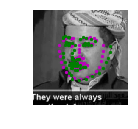

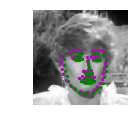

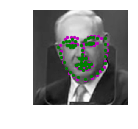

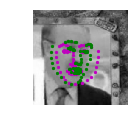

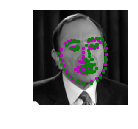

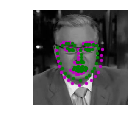

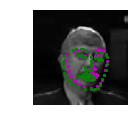

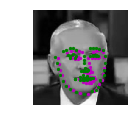

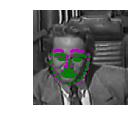

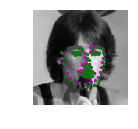

In [27]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [28]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Since this is a regression problem, regression losses would be appropriate. MSELoss seems to work well.  

For optimizer, I chose tried SGD as well as Adam and chose the latter.  Using the default parameters of $\alpha=0.001, \beta_1=0.99, \beta_2=0.999$ worked well.  I also tried a few other values of $\alpha$ before settling on this.  Adam is often a stable optimizer and coverges faster than SGD.  It combines the benefits of RMSprop and Momentum. 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:The architecture has 4 conv layers and 3 dense layers.  There is ReLU activation and dropout following each layer in the network.  In addition, after each of the convolutional layers, there is batch normalization and maxpooling with stride 2 and pool size 2.

He initialization (using nn.kaiming_normal_() ) is preferred here over Xavier initialization since the activations here are ReLU. 

The number of channels doubles in each convolutional layer. I have tried various filter sizes and strides in the convolutional layers and have left all but one of the convolutional layers with a filter size of (5,5). 

My initial architecture did not have dropout, had only 3 conv layers and had 2 dense layers.  The training loss got low, but I did not find the performance on the test set to be satisfactory.   Since there are 6 dropout layers, the final network architecture is much more regularized, even though the training loss is not as low as without the dropout.

Adding the intializations helped train faster.


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

`batch_size` is an interesting parameter.  The larger it is (without running out of memory), the quicker the training is.  I tried up to a batch size of 50.  However, there is also a higher training loss with a larger `batch_size`. 

One way to deal with that is to take advantage of the faster training to simply increase the number of epochs and lower the loss with more epochs of training.  

As for epochs, it's not a good idea to use "early stopping" as a method of regularization because it does not allow for a separation of the bias and variance reduction problems (ideally, we first want to reduce training loss as much as we can and then try our best to reduce the testing loss and early stopping does not allow that).

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.21474165 -0.11615474 -0.31639856 -0.5903007  -0.21693812]
 [-0.21783799 -0.25987867 -0.07128542 -0.05026979 -0.08452644]
 [ 0.15246767 -0.00505886 -0.10117706 -0.41614792 -0.16021287]
 [ 0.25147817 -0.33164877 -0.11983816 -0.10493159  0.45091695]
 [ 0.11012216  0.19853061  0.14381403  0.23495501 -0.5719044 ]]
(5, 5)


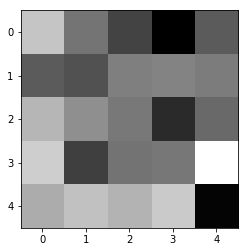

In [29]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

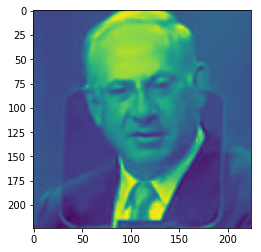

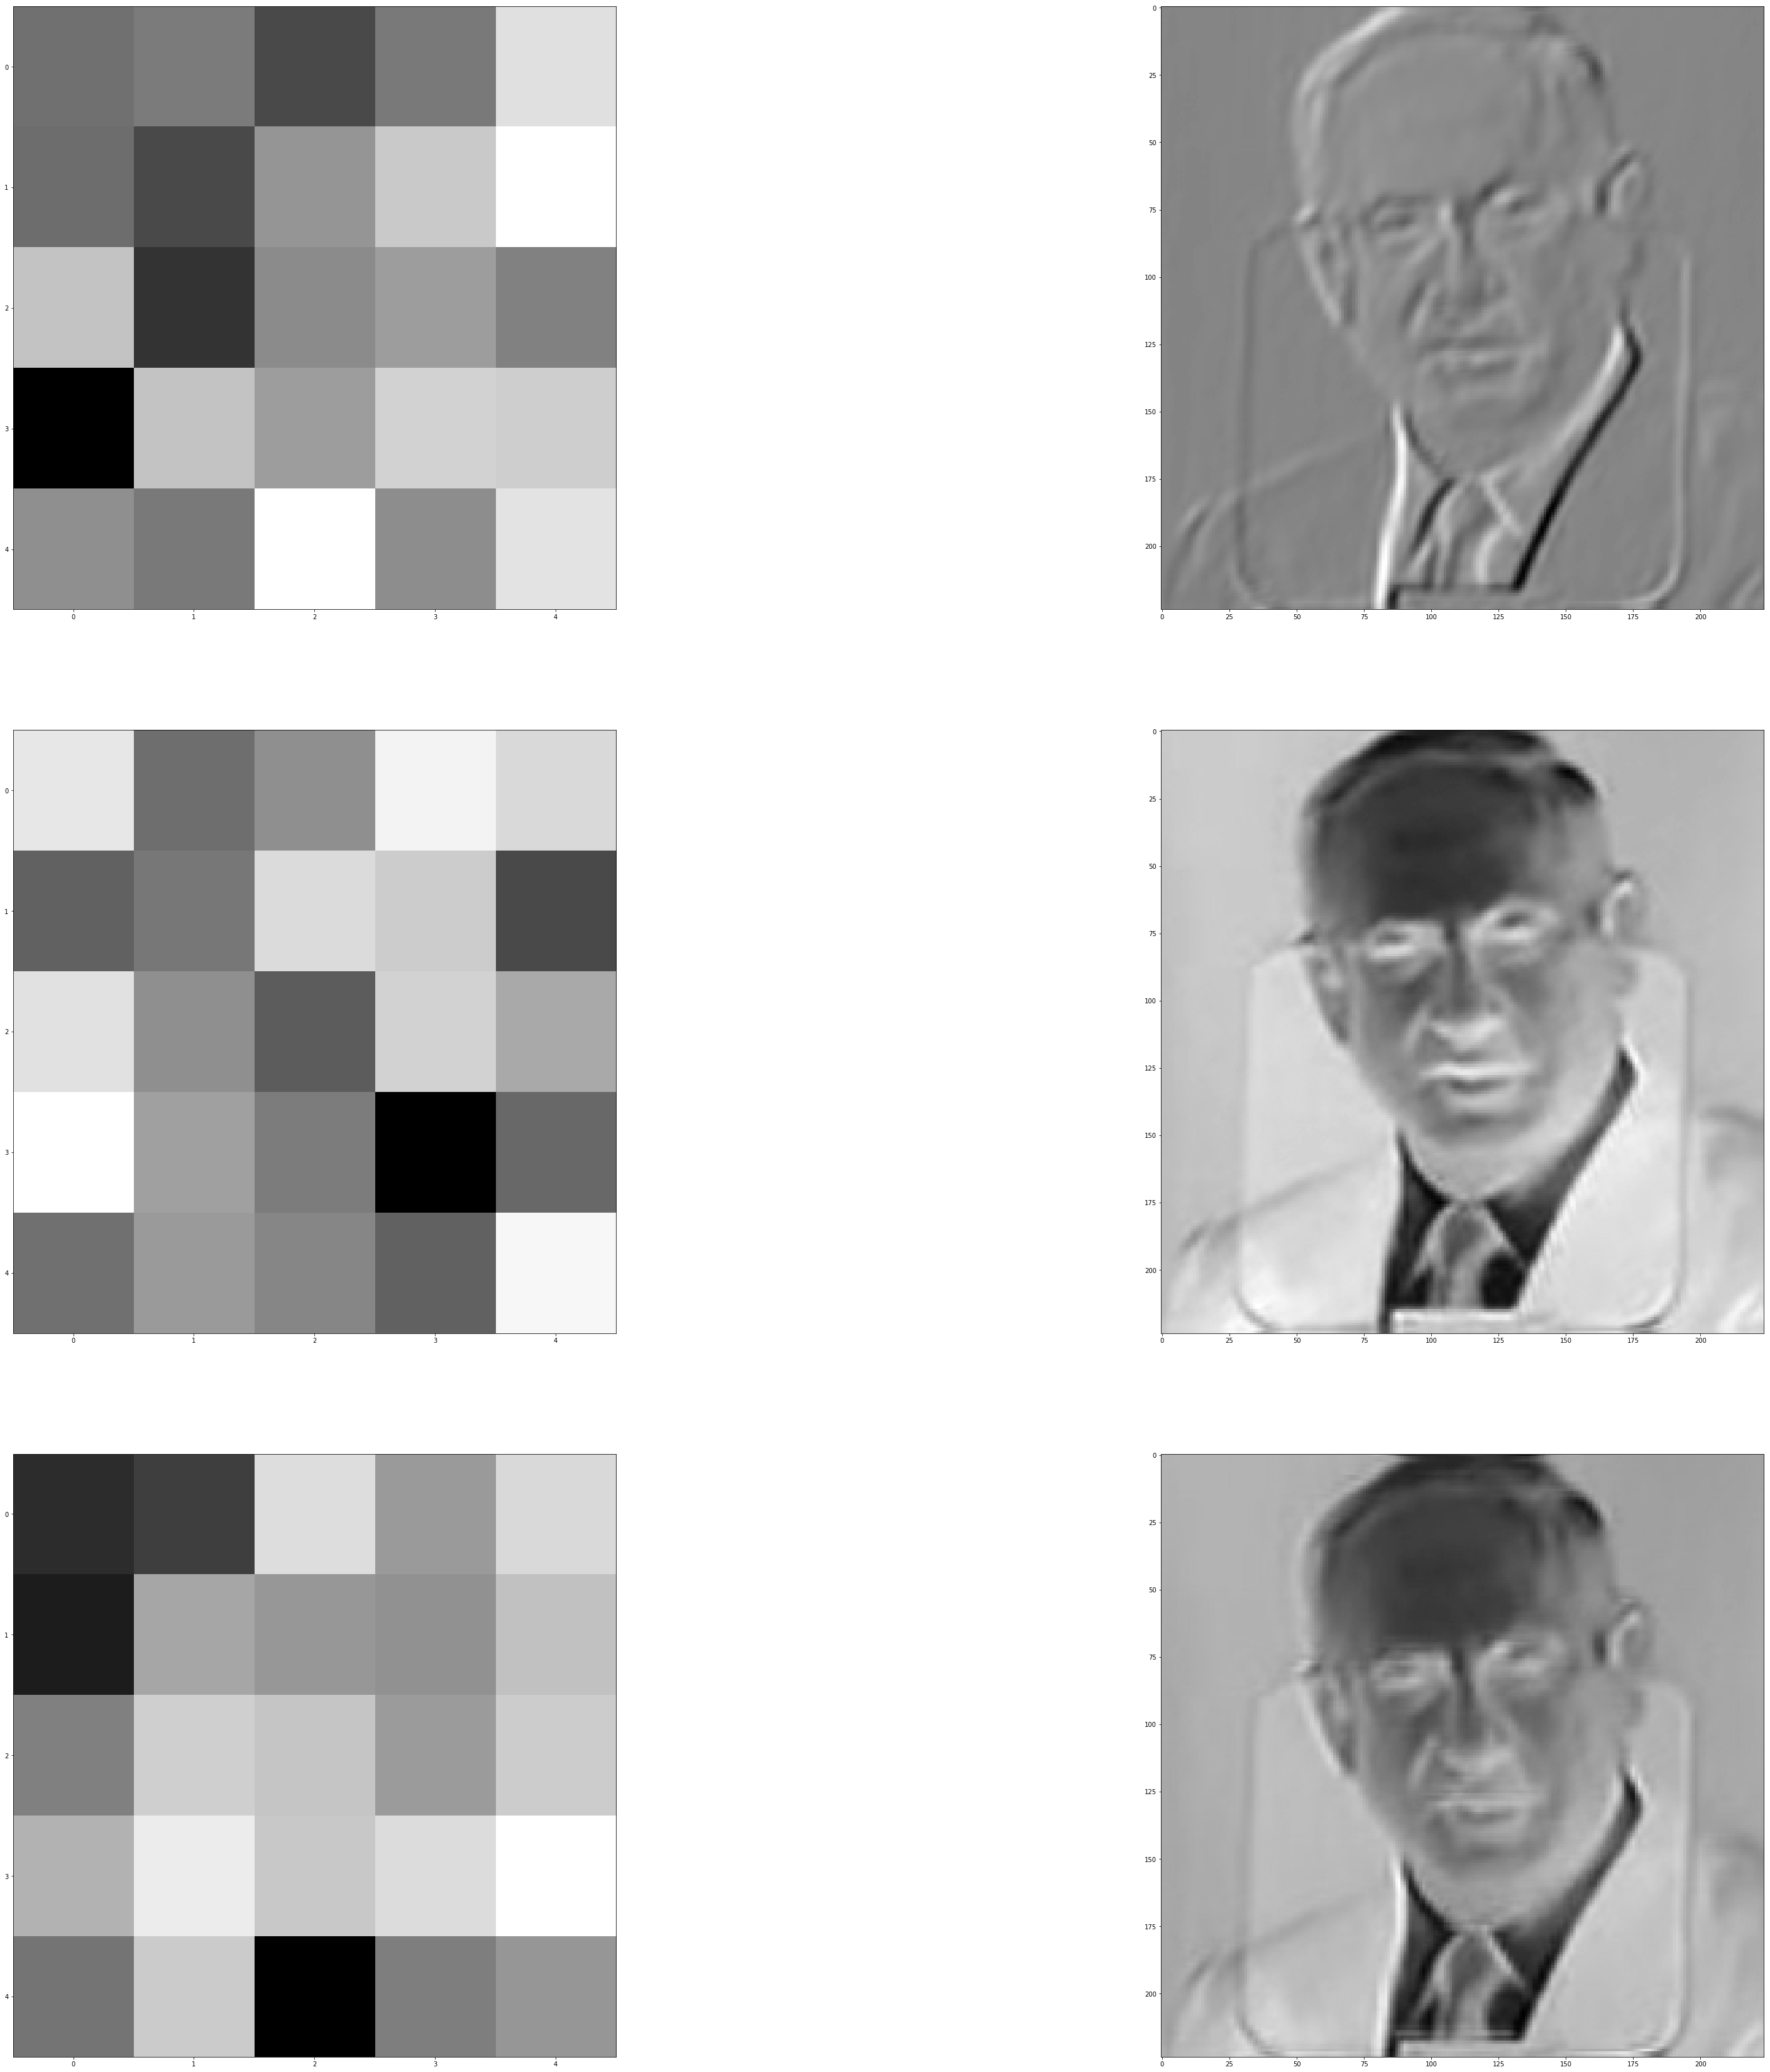

In [32]:
##TODO: load in and display any image from the transformed test dataset
# obtain one batch of testing images
# img=test_images[0]

# un-transform the image data
image = test_images[2].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)
plt.imshow(image)

# # Use OpenCV's filter2D function 
# # apply a specific set of filter weights (like the one's displayed above) to the test image
weights = net.conv1.weight.data
w = weights.numpy()

import cv2
# plt.imshow(img, cmap='gray')
# ## TODO: Using cv's filter2D function,
# ## apply a specific set of filter weights (like the one displayed above) to the test image

fig=plt.figure(figsize=(60, 60))
filters=[3,5,6]
f_names=['dark detector','vertical edge: brighter on the right','horizontal edge. brighter below']
columns = 2
rows = len(filters)
# for i in range(0, columns*rows):
# for i in range(0, rows*columns):
#     fig.add_subplot(rows, columns, i+1)
#     if ((i%2)==0):
#         plt.imshow(w[filters[int(i/2)]][0], cmap='gray')
#     else:
#         c = cv2.filter2D(image, -1, w[filters[int((i-1)/2)]][0])
#         plt.imshow(c, cmap='gray')
# plt.show()

for i in range(0, rows*columns):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[filters[int(i/2)]][0], cmap='gray')
    else:
        c = cv2.filter2D(image, -1, w[filters[int((i-1)/2)]][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: 

Of the 3 filters chosen for display here, the first one seems to detect darkness (brightness). It produces the highest values in the blackest regions of the original image and lowest values in the brightest parts of the original image).

The second filter is a vertical edge detector that has the highest values when the x-gradients in the original image are the highest, *i.e.*, the vertical edges which have darkness on the left and brighness on the right.

The third filter is a horizontal edge detector that has the highest values when the vertical gradients in the original image are the highest, *i.e.*, the horizontal edges which have darkness below and brighness above them in the original image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!